## Load Data

In [1]:
from google.colab import drive
import os
import pandas as pd
import numpy as np

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define project paths
project_dir = '/content/drive/MyDrive/4awesome/'
data_dir = '/content/drive/MyDrive/4awesome/Data'

reviews = pd.read_csv(os.path.join(data_dir, 'reviews_with_policy_flags.csv'))

Mounted at /content/drive


## Import Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import shap
from scipy.sparse import hstack

## Feature and Target Selection

### Choice of Target Variables: `rating` and `rating_category`

1. **`rating` (1–5)**  
   - Provides a direct and quantitative measure of user satisfaction.  
   - Serves as the most widely recognized indicator of review quality on platforms like Google Maps.  
   - Predicting ratings helps us assess whether the model captures the overall **sentiment intensity** of a review.

2. **`rating_category` (e.g., taste, menu, atmosphere)**  
   - Captures what aspect of the business the review is addressing.  
   - Goes beyond sentiment to highlight context and relevance of user feedback.  
  

By combining both targets, we can evaluate reviews along two important dimensions:
- **Quality**: how satisfied the customer was (`rating`).  
- **Relevance**: what aspect of the experience drove the review (`rating_category`).  




In [21]:
# Targets

# Aspect classification
y_aspect = reviews["rating_category"]

# Sentiment classification (convert stars → positive/neutral/negative)
def map_sentiment(rating):
    if rating <= 2:
        return "negative"
    elif rating == 3:
        return "neutral"
    else:
        return "positive"

y_sentiment = reviews["rating"].apply(map_sentiment)

print("Aspect classes:", y_aspect.unique())
print("Sentiment classes:", y_sentiment.unique())


# Features
text = reviews["cleaned_text"].fillna("")

engineered_features = reviews[[
    "promotional_score", "sentiment_polarity", "sentiment_subjectivity",
    "char_count", "avg_word_len", "unique_word_ratio",
    "vader_pos", "vader_neg", "vader_neu", "vader_compound"
]]

Aspect classes: ['taste' 'menu' 'outdoor_atmosphere' 'indoor_atmosphere']
Sentiment classes: ['positive' 'neutral' 'negative']


## Train/test Split

* **`X_train_text`**/**`X_test_text`**: Raw text
* **`X_train_num`**/**`X_test_num`**: Engineered Numeric Features
* **`y_train_aspect`**/**`y_test_aspect`**: rating_category
* **`y_train_sent`**/**`y_test_sent`**: rating

In [22]:
X_train_text, X_test_text, y_train_aspect, y_test_aspect, y_train_sent, y_test_sent, X_train_num, X_test_num = train_test_split(
    text, y_aspect, y_sentiment, engineered_features,
    test_size=0.2, random_state=42, stratify=y_aspect
)

## TF-IDF Vectorization

Converts text into numerical vectors. Uses TF-IDF with unigrams + bigrams (single words + word pairs) and keeps top 5000 most informative terms

In [23]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

## Logistic Regression (Aspect)

=== Logistic Regression (Aspect Classification) ===
Accuracy: 0.3598130841121495
                    precision    recall  f1-score   support

 indoor_atmosphere       0.37      0.37      0.37        57
              menu       0.38      0.08      0.13        37
outdoor_atmosphere       0.39      0.27      0.32        55
             taste       0.34      0.58      0.43        65

          accuracy                           0.36       214
         macro avg       0.37      0.33      0.31       214
      weighted avg       0.37      0.36      0.34       214



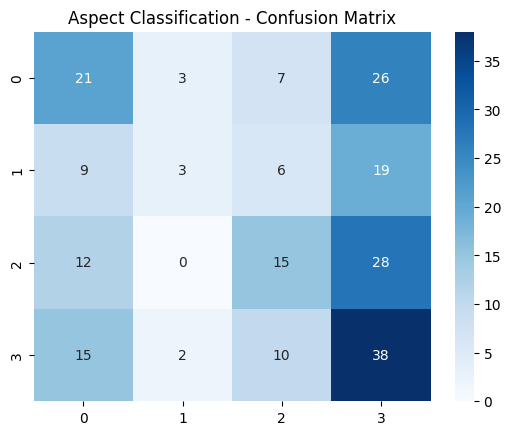

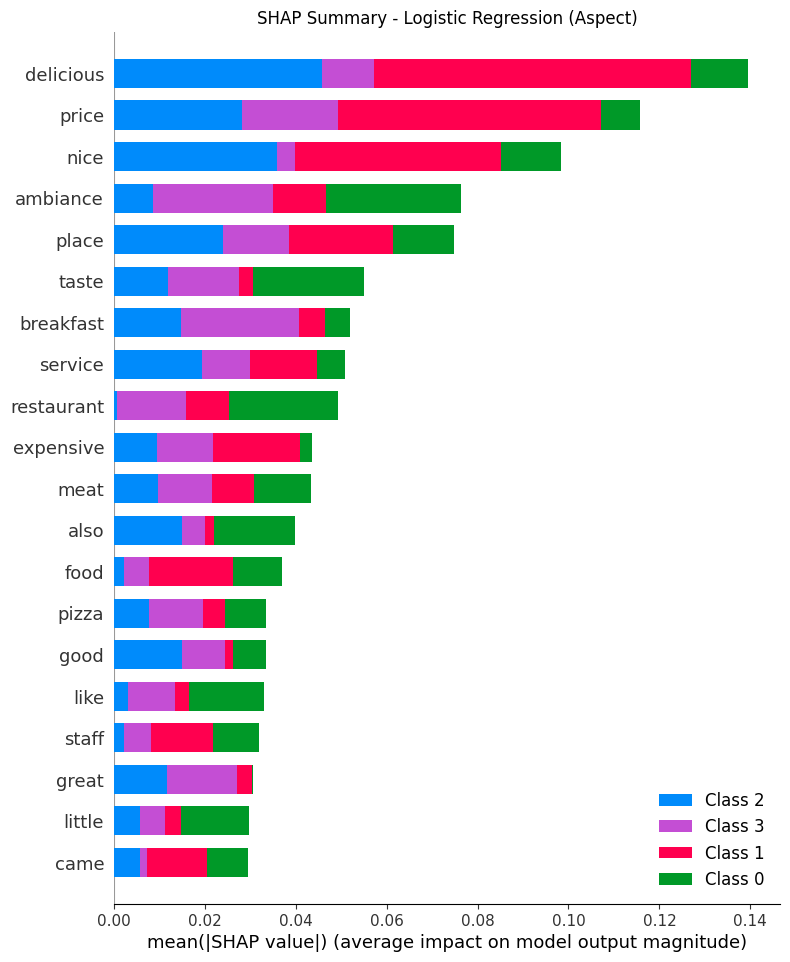

In [29]:
print("=== Logistic Regression (Aspect Classification) ===")
log_reg_aspect = LogisticRegression(max_iter=200)
log_reg_aspect.fit(X_train_tfidf, y_train_aspect)
y_pred_aspect = log_reg_aspect.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_aspect, y_pred_aspect))
print(classification_report(y_test_aspect, y_pred_aspect))

sns.heatmap(confusion_matrix(y_test_aspect, y_pred_aspect), annot=True, fmt="d", cmap="Blues")
plt.title("Aspect Classification - Confusion Matrix")
plt.show()

feature_names = tfidf.get_feature_names_out()
explainer_aspect = shap.LinearExplainer(log_reg_aspect, X_train_tfidf, feature_names=feature_names)
shap_values_aspect = explainer_aspect(X_test_tfidf)
shap.summary_plot(shap_values_aspect, X_test_tfidf, feature_names=feature_names, show=False)
plt.title("SHAP Summary - Logistic Regression (Aspect)")
plt.show()

## Logistic Regression (Sentiment)

=== Logistic Regression (Sentiment Classification) ===
Accuracy: 0.6915887850467289
              precision    recall  f1-score   support

    negative       0.50      0.03      0.06        30
     neutral       0.50      0.03      0.05        38
    positive       0.70      1.00      0.82       146

    accuracy                           0.69       214
   macro avg       0.57      0.35      0.31       214
weighted avg       0.63      0.69      0.58       214



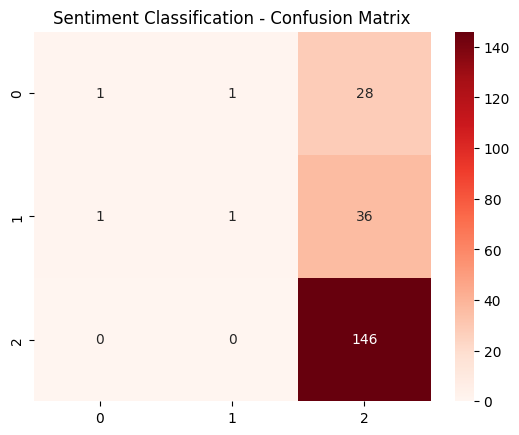

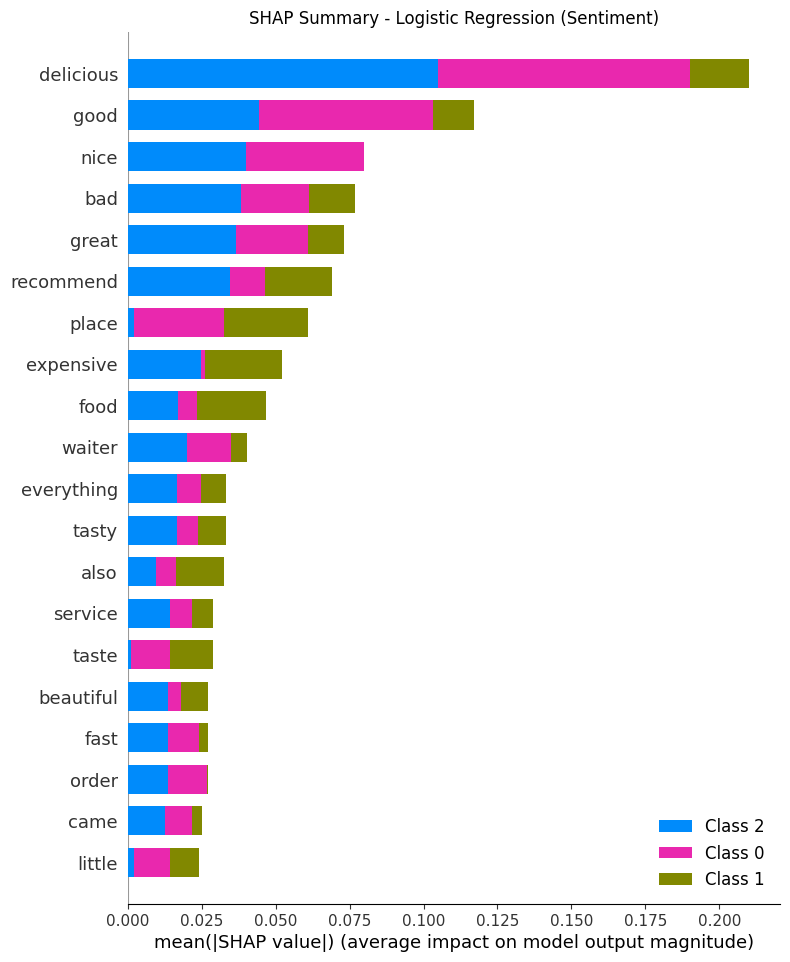

In [28]:
print("=== Logistic Regression (Sentiment Classification) ===")
log_reg_sent = LogisticRegression(max_iter=200)
log_reg_sent.fit(X_train_tfidf, y_train_sent)
y_pred_sent = log_reg_sent.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_sent, y_pred_sent))
print(classification_report(y_test_sent, y_pred_sent))

sns.heatmap(confusion_matrix(y_test_sent, y_pred_sent), annot=True, fmt="d", cmap="Reds")
plt.title("Sentiment Classification - Confusion Matrix")
plt.show()

# SHAP for Logistic Regression (Sentiment)
explainer_sent = shap.LinearExplainer(log_reg_sent, X_train_tfidf, feature_names=feature_names)
shap_values_sent = explainer_sent(X_test_tfidf)
shap.summary_plot(shap_values_sent, X_test_tfidf, feature_names=feature_names, show=False)
plt.title("SHAP Summary - Logistic Regression (Sentiment)")
plt.show()